In [2]:
# Let's follow adding image sizes :
#   https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson7.ipynb

In [45]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import gc, math
import pickle
import collections
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import Model, load_model, model_from_json

from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

from cnnmodels import vgg_std16_model, preprocess_input, create_rect5, load_img, train_generator, test_generator
from cnnmodels import identity_block, testcv_generator, conv_block, resnet50_model

In [4]:
# Params
img_rows, img_cols = 224, 224 # Resolution of inputs
channel = 3
ROWS, COLS = 224, 224
#CHECKPOINT_DIR = 'log/checkpoint06/'
BATCHSIZE = 32
CERV_CLASSES = ['Type_1', 'Type_2', 'Type_3']
nb_perClass = int(BATCHSIZE / len(CERV_CLASSES))
TRAIN_DIR = '../data/cropped/train'
TEST_DIR = '../data/cropped/test'
DATA_DIR = '../data'
num_class = len(CERV_CLASSES)
full = False
bags = 5

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=180,
    shear_range=0.2,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

In [7]:
img_ls = []
y_ls = []
for typ in CERV_CLASSES:
    for img in os.listdir(os.path.join(TRAIN_DIR, typ)):
        if img != '.DS_Store':
            img_ls.append(os.path.join(TRAIN_DIR, typ, img))
            y_ls.append(typ)
# for typ in CERV_CLASSES:
#     for img in os.listdir(os.path.join(DATA_DIR, typ)):
#         if img != '.DS_Store':
#             img_ls.append(os.path.join(DATA_DIR, typ, img))
#             y_ls.append(typ)
train_all  = pd.DataFrame({'class': y_ls, 'img': img_ls, })[['img', 'class']]

In [8]:
train_all.tail(2)

,img,class
8210,../data/cropped/train/Type_3/774_cropped.jpg,Type_3
8211,../data/cropped/train/Type_3/5107_T3_additiona...,Type_3


In [9]:
# Get the same validation set in terms of the new naming for the crops
trnidx = []
for c, row in train_all.iterrows():
    typ = row['img'].split('/')[-2]
    additional = True if 'additional' in row['img'] else False
    img = row['img'].split('/')[-1].split('_')[0]
    if additional:
        trnidx.append(typ+'/'+img+'.jpg')
    else:
        trnidx.append('train/'+typ+'/'+img+'.jpg')
print trnidx[:10]

['Type_1/1987.jpg', 'Type_1/3159.jpg', 'Type_1/5359.jpg', 'Type_1/1243.jpg', 'Type_1/3583.jpg', 'Type_1/5983.jpg', 'Type_1/2432.jpg', 'train/Type_1/901.jpg', 'Type_1/6505.jpg', 'Type_1/979.jpg']


In [46]:
def resnet50_model_sizes(img_rows, img_cols, color_type=1, num_class=None):
    """
    Resnet 50 Model for Keras
    Model Schema is based on 
    https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
    ImageNet Pretrained Weights 
    https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_th_dim_ordering_th_kernels.h5
    Parameters:
      img_rows, img_cols - resolution of inputs
      channel - 1 for grayscale, 3 for color 
      num_class - number of class labels for our classification task
    """

    bn_axis = 1
    img_input = Input(shape=(color_type, img_rows, img_cols))
    x = ZeroPadding2D((3, 3))(img_input)
    x = Convolution2D(64, 7, 7, subsample=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    # Fully Connected Softmax Layer
    x_fc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_fc = Flatten()(x_fc)
    x_fc = Dense(1000, activation='softmax', name='fc1000')(x_fc)

    # Create model
    model = Model(img_input, x_fc)

    # Load ImageNet pre-trained data 
    model.load_weights('../cache/resnet50_weights_th_dim_ordering_th_kernels.h5')

    sz_inp = Input((len(id2size),))
    bn_inp = BatchNormalization()(sz_inp)
    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_newfc = Flatten()(x_newfc)
    x_newfc = merge([x_newfc, bn_inp], 'concat')
    x_newfc = Dense(num_class, activation='softmax', name='fc10')(x_newfc)
    

    # Create another model with our customized softmax
    model = Model(img_input, x_newfc)

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  
    return model

In [10]:
img_ls = []
for img in os.listdir(TEST_DIR):
    if img != '.DS_Store':
        img_ls.append(os.path.join(TEST_DIR, img))
test_df  = pd.DataFrame({'img': img_ls}) 

In [11]:
def train_generator(datagen, df):
    while 1:
        batch_x = np.zeros((BATCHSIZE, ROWS, COLS, 3), dtype=K.floatx())
        batch_y = np.zeros((BATCHSIZE, len(CERV_CLASSES)), dtype=K.floatx())
        fn = lambda obj: obj.loc[np.random.choice(obj.index, size=nb_perClass, replace=False),:]
        batch_df = df.groupby('class', as_index=True).apply(fn)
        i = 0
        for index,row in batch_df.iterrows():
            row = row.tolist()
            image_file = row[0]
            typ_class = row[1]
            img = Image.open(image_file).resize((ROWS, COLS))
            img = img.convert('RGB')
            x = np.asarray(img, dtype=K.floatx())
            #x = datagen.random_transform(x)
            x = preprocess_input(x)
            batch_x[i] = x
            batch_y[i,CERV_CLASSES.index(typ_class)] = 1
            i += 1
        #return (batch_x, batch_y)
        yield (batch_x.transpose(0, 3, 1, 2), batch_y)

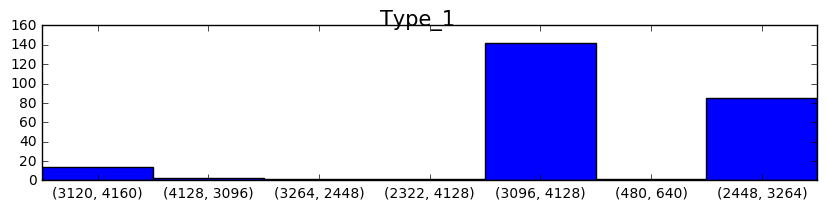

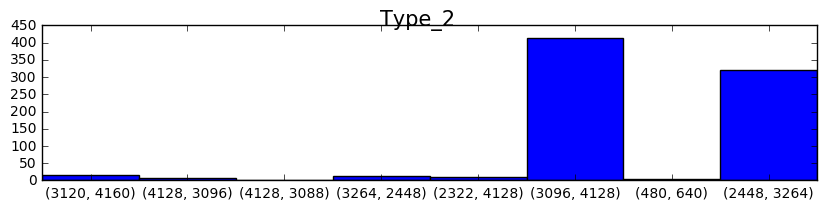

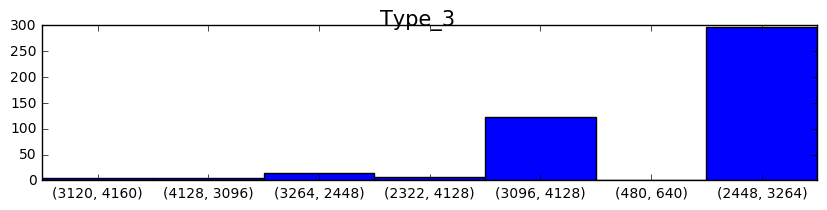

In [44]:
import collections

for typ in range(1,4):
    sizes = [str(Image.open(os.path.join(DATA_DIR, f)).size) for f in trnidx if 'train/Type_'+str(typ) in f]
    labels, values = zip(*collections.Counter(sizes).items())
    indexes = np.arange(len(labels))
    width = 1
    plt.figure(figsize=(10,2))
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.suptitle('Type_'+str(typ), fontsize=15)
    plt.show()

In [48]:
# Load up the image sizes to see if there is some leak
tstidx = test_df.img.str.replace("/cropped", "").str.replace("_cropped", "").tolist()
sizes = [Image.open(os.path.join(DATA_DIR, f)).size for f in trnidx + tstidx]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}
sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))

import collections
collections.Counter(sizes)

Counter({(480, 640): 76,
         (640, 480): 1,
         (2322, 4128): 99,
         (2448, 3264): 4134,
         (3096, 4128): 3761,
         (3120, 4160): 440,
         (3264, 2448): 166,
         (4128, 3088): 1,
         (4128, 3096): 46})

In [49]:
# Normalise the sizes
sizes_all = sizes_orig-sizes_orig.mean(axis=0)/sizes_orig.std(axis=0)
trn_sizes_all = sizes_all[:len(trnidx)]
tst_sizes = sizes_all[len(trnidx):]
print(trn_sizes_all.shape)
print(tst_sizes.shape)
trn_sizes_all[:3]

(8212, 9)
(512, 9)


array([[-0.10713665, -0.09374518, -0.01070698, -0.13927331, -0.07280632,
        -0.2304657 , -0.01070698, -0.87052155,  0.05097229],
       [-0.10713665, -0.09374518, -0.01070698, -0.13927331, -0.07280632,
         0.7695343 , -0.01070698, -0.87052155, -0.94902771],
       [-0.10713665, -0.09374518, -0.01070698, -0.13927331, -0.07280632,
        -0.2304657 , -0.01070698, -0.87052155,  0.05097229]])

In [50]:
# Split into train and valid
valid_set = pd.read_csv("../val_images.csv", header = None, names = ['img']).img.tolist()
print(valid_set[-4:])
print(valid_set[:4])

['Type_2/3498.jpg', 'Type_2/1341.jpg', 'Type_3/6017.jpg', 'Type_2/5629.jpg']
['Type_2/1315.jpg', 'train/Type_2/162.jpg', 'train/Type_2/270.jpg', 'train/Type_2/382.jpg']


In [63]:
valid_df = train_all[[f in valid_set for f in trnidx]]
idx = np.array([f in valid_set for f in trnidx])
val_sizes = trn_sizes_all[idx]

if full == True:
    train_df = train_all
    trn_sizes = trn_sizes_all
else:
    train_df = train_all[[f not in valid_set for f in trnidx]]
    trn_sizes = trn_sizes_all[~idx]
    
samples_per_epoch=BATCHSIZE*math.ceil(train_df.groupby('class').size()['Type_2']/nb_perClass)
print(train_df.shape)
print(valid_df.shape)
print(trn_sizes.shape)
print(val_sizes.shape)

(6570, 2)
(1642, 2)
(6570, 9)
(1642, 9)


In [ ]:
# Make our validation set
l = valid_df.groupby('class').size()
valid_x = np.zeros((valid_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
valid_y = np.zeros((valid_df.shape[0], len(CERV_CLASSES)), dtype=K.floatx())
i = 0
for index,row in valid_df.iterrows():
    row = row.tolist()
    image_file = row[0]
    typ_class = row[1]
    img = Image.open(image_file).resize((ROWS, COLS))
    img = img.convert('RGB')
    x = np.asarray(img, dtype=K.floatx())
    # x = datagen.random_transform(x)
    x = preprocess_input(x)
    valid_x[i] = x
    valid_y[i,CERV_CLASSES.index(typ_class)] = 1
    i += 1
valid_x = valid_x.transpose(0, 3, 1, 2)

In [ ]:
def test_generator(df, datagen, batch_size = BATCHSIZE):
    n = df.shape[0]
    batch_index = 0
    while 1:
        current_index = batch_index * batch_size
        if n >= current_index + batch_size:
            current_batch_size = batch_size
            batch_index += 1    
        else:
            current_batch_size = n - current_index
            batch_index = 0        
        batch_df = df[current_index:current_index+current_batch_size]
        batch_x = np.zeros((batch_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
        i = 0
        for index,row in batch_df.iterrows():
            row = row.tolist()
            image_file = row[0]
            # typ_class = row[1]
            img = Image.open(image_file).resize((ROWS, COLS))
            img = img.convert('RGB')
            x = np.asarray(img, dtype=K.floatx())
            # x = datagen.random_transform(x)
            x = preprocess_input(x)
            batch_x[i] = x
            i += 1
        if batch_index%100 == 0: print(batch_index)
        # return (batch_x.transpose(0, 3, 1, 2))
        yield(batch_x.transpose(0, 3, 1, 2))

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')        
model_checkpoint = ModelCheckpoint(filepath=CHECKPOINT_DIR+'weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
# learningrate_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)
# tensorboard = TensorBoard(log_dir=LOG_DIR, histogram_freq=0, write_graph=False, write_images=True)

In [ ]:
print "Model creation... "
nb_epoch = 2
model = resnet50_model(ROWS, COLS, channel, num_class)
for layer in model.layers:
    layer.trainable = False
for layer in model.layers[-3:]:
    layer.trainable = True
    
model.optimizer.lr = 1e-5
# Start Fine-tuning
print "Fine tune part 1"
model.fit_generator(train_generator(train_datagen, train_df),
          nb_epoch=nb_epoch,
          samples_per_epoch=samples_per_epoch, #50000,
          verbose=1,
          validation_data=(valid_x, valid_y),
          #callbacks=[early_stopping, model_checkpoint],
          )

In [ ]:
### Resnet50
# fine tuning
# 164 conv5c+top
# 142 conv5+top
# 80 conv4+conv5+top
# 38 conv3+conv4+conv5+top
start_layer = 164

for layer in model.layers[start_layer:]:
    layer.trainable = True
model.optimizer.lr = 1e-6
nb_epoch = 10

In [ ]:
print "Fine tune part 2"
model.fit_generator(train_generator(train_datagen, df=train_df),
          nb_epoch=nb_epoch,
          samples_per_epoch=samples_per_epoch,
          verbose=1,
          validation_data=(valid_x, valid_y),
          #callbacks=[model_checkpoint, early_stopping], # , 
          )

In [ ]:
# fine tuning
# 164 conv5c+top
# 142 conv5+top
# 80 conv4+conv5+top
# 38 conv3+conv4+conv5+top
start_layer = 142
for layer in model.layers[start_layer:]:
    layer.trainable = True
model.optimizer.lr = 1e-6
nb_epoch = 10
print "Fine tune part 3"
model.fit_generator(train_generator(train_datagen, df=train_df),
          nb_epoch=nb_epoch,
          samples_per_epoch=samples_per_epoch,
          verbose=1,
          validation_data=(valid_x, valid_y),
          #callbacks=[model_checkpoint, early_stopping], # , 
          )

In [ ]:
#from keras.models import load_model, model_from_json
#model = load_model('log/checkpoint01weights.003-0.7728.hdf5')

In [ ]:
#learningrate_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)

In [ ]:
# Hack to solve issue on model loading : https://github.com/fchollet/keras/issues/4044
import glob
import h5py
model_files = sorted(glob.glob(CHECKPOINT_DIR + '*.hdf5'))
for model_file in model_files:
    print("Update '{}'".format(model_file))
    with h5py.File(model_file, 'a') as f:
        if 'optimizer_weights' in f.keys():
            del f['optimizer_weights']

### Try a prediction from a single epoch

In [ ]:
model = load_model(CHECKPOINT_DIR + 'weights.009-0.2856.hdf5')

In [ ]:
test_preds = model.predict_generator(test_generator(test_df, train_datagen), 
                                         val_samples = test_df.shape[0])

In [ ]:
test_sub = pd.DataFrame(test_preds, columns=CERV_CLASSES)
test_sub['image_name'] = test_df['img'].str.split('/').apply(lambda x: x[-1])
test_sub = test_sub[['image_name'] + CERV_CLASSES ]
test_sub.head(3)

In [ ]:
import time
timestr = time.strftime("%Y%m%d")
if full:
    subm_name = '../sub/sub_dara_full_resnet_raw_' + timestr + '.csv' #'.csv.gz'
else:
    subm_name = '../sub/sub_dara_part_resnet_raw_' + timestr + '.csv' #'.csv.gz'

In [ ]:
from IPython.lib.display import FileLink
#test_sub.to_csv(subm_name, index=False)#, compression='gzip')
#FileLink(subm_name)

### Bag the predictions from a few epochs

In [ ]:
import glob
files = glob.glob(CHECKPOINT_DIR+'*')
# there is apparently overfitting on the later epochs so exclude the epochs where we unfroze the top layers
files = [f for f in files if float(f.split('-')[-1][:-5])>0.26]
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
min_id = np.array(val_losses).argsort()[:bags].tolist()

In [ ]:
# Loop the lowest val losses and get a prediction for each
test_preds_ls = []
for index in min_id:
    print('Loading model from checkpoints file ' + files[index])
    test_model = load_model(files[index])
    test_model_name = files[index].split('/')[-2][-1:]+'_'+files[index].split('/')[-1]
    test_preds_ls.append(test_model.predict_generator(test_generator(test_df, train_datagen), 
                                         val_samples = test_df.shape[0])) 
    del test_model
    gc.collect()

In [ ]:
test_preds = sum(test_preds_ls)/len(test_preds_ls)

In [ ]:
test_sub = pd.DataFrame(test_preds, columns=CERV_CLASSES)
test_sub['image_name'] = test_df['img'].str.split('/').apply(lambda x: x[-1])
test_sub = test_sub[['image_name'] + CERV_CLASSES ]
test_sub.head(3)

In [ ]:
if full:
    subm_name = '../sub/sub_dara_full_resnet_raw_5xbag_' + timestr + '.csv' #'.csv.gz'
else:
    subm_name = '../sub/sub_dara_part_resnet_raw_5xbag_' + timestr + '.csv' #'.csv.gz'
    
#test_sub.to_csv(subm_name, index=False)#, compression='gzip')
#FileLink(subm_name)